# dataloader 

In [ ]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

In [ ]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/'My Drive'

 0243374C-0F39-4AAE-9C93-3249C62A6ED3.jpeg
 2019_data_analyst_jobs.gsheet
 20200529093419733.pdf
'Appunti di Giovanni - Fisica II'
'Bakery Sales March 2020.gsheet'
 BeatriceCMarrano_CV.pdf
 Classroom
'Colab Notebooks'
'Copia di Cosmetics Inc. (1).gsheet'
'Copia di Cosmetics Inc..gsheet'
'Course 4 Week 2 Glossary | DA terms and definitions.gdoc'
'Data Spreadsheet for "Cleaning with Spreadsheets" .gsheet'
'Dynamic Dataset.gsheet'
 E5F47663-C5A7-40C4-8536-9F93CAC746AB.jpeg
'Example Spreadsheet - Entertainment Expenses .gsheet'
'Global Logistics Association - Data to Merge.gsheet'
 images
'June 2014 Invoices.gsheet'
'Movie Data Starter Project.gsheet'
 Outlook
 p
'Room 2F.1.12 - Beatrice Marrano - Studio L - signed(1) (1).gdoc'
'Room 2F.1.12 - Beatrice Marrano - Studio L - signed(1) (2).gdoc'
'Room 2F.1.12 - Beatrice Marrano - Studio L - signed(1).gdoc'
'Room 2F.1.12 - Beatrice Marrano - Studio L - signed(1).pdf'
'Sample Size Calculator.gsheet'
 sample_submission.csv
'Sample Transaction Ta

In [ ]:
drive_path = 'drive/My Drive/'

In [ ]:
count_images = len(glob.glob("drive/My Drive/p/*/*.npy"))
print("Total Observations:\t", count_images)

Total Observations:	 11464


---

In [ ]:
folders= [name for name in os.listdir("drive/My Drive/p/") if os.path.isdir('drive/My Drive/p/'+name)][1:]

In [ ]:
folders

['Week8_4sites_G02_s4_w15F47AE57-AC34-49C6-97E7-8CEA26BE83E0',
 'Week8_4sites_G02_s4_w1CED69CBA-FCC9-4E50-B9DF-890C22C4F4F1',
 'Week8_4sites_G02_s4_w1DCA9961B-DBD3-429C-97D2-340F8393075F',
 'Week8_4sites_G02_s4_w15009F180-5183-4903-A7D8-7938589AD6CE',
 'Week8_4sites_G02_s4_w177DDFAB4-060A-43E8-B518-B71A77368080',
 'Week8_4sites_G11_s1_w1F302A162-2266-4CD2-8052-63235C48D104',
 'Week8_4sites_G11_s1_w1D9DA2986-8D29-41C9-A3B4-E7910167C5C6',
 'Week8_4sites_G11_s1_w1B546843F-3450-4968-83C4-9F952462852A',
 'Week9_090907_B11_s1_w1D93D91E4-BDFC-469B-9A49-F33D7864D113',
 'Week9_090907_B05_s4_w107B51C3B-D57D-41BA-B38F-6737973E906C',
 'Week9_090907_B11_s1_w19C5ECE73-EE7D-46DA-889B-D6AEDDC9C2F4',
 'Week9_090907_B05_s4_w1888F5C9E-84CB-41CC-B5D2-E6721341681F',
 'Week9_090907_B05_s4_w1DF204CCF-D198-4D18-BB6A-154F7FFBAC37',
 'Week9_090907_B05_s3_w17B45A6B7-91CA-4DD1-8D17-86A2D6A72F9E',
 'Week9_090907_B05_s3_w1EE23ABFE-A7D8-4360-AA72-A49701D86FA0',
 'Week9_090907_B11_s1_w1AEE0ACA4-6408-4E7A-AA82-9801674

In [ ]:
metadata = pd.read_csv('drive/My Drive/p/metadata.csv')

In [ ]:
u = metadata.moa.unique()

In [ ]:
moa_id = {}
for i in range(len(u)):
    moa_id[u[i]] = i

In [ ]:
moa_id

{'DMSO': 0,
 'Microtubule stabilizers': 1,
 'Eg5 inhibitors': 2,
 'Epithelial': 3,
 'Actin disruptors': 4,
 'Microtubule destabilizers': 5,
 'Aurora kinase inhibitors': 6,
 'Protein degradation': 7,
 'DNA replication': 8,
 'DNA damage': 9,
 'Protein synthesis': 10,
 'Kinase inhibitors': 11,
 'Cholesterol-lowering': 12}

In [ ]:
metadata_usable = metadata.loc[:,(metadata.columns == "Single_Cell_Image_Name") | (metadata.columns == 'moa')]

In [ ]:
prop_dmso = np.floor((metadata_usable.moa.value_counts().median()/metadata_usable.moa.value_counts().sum())*count_images)

In [ ]:
metadata_usable.moa.value_counts()

DMSO                         276360
Microtubule stabilizers       89157
Aurora kinase inhibitors      16810
DNA damage                    16582
Microtubule destabilizers     15178
Epithelial                    14955
Eg5 inhibitors                12525
Kinase inhibitors             11622
Protein synthesis              9715
Actin disruptors               7491
Protein degradation            6589
DNA replication                5976
Cholesterol-lowering           5436
Name: moa, dtype: int64

In [ ]:
dataset_train = []
dataset_test = []
count_dmso = 0
count_test = 0


for folder in folders:
    images = listdir('drive/My Drive/p/'+folder)
    
    for image in images:
        
        single_cell_image = np.load('drive/My Drive/p/'+folder+'/'+image)
        single_cell_image = torch.tensor(single_cell_image.astype(np.float32))
        idx = metadata_usable.Single_Cell_Image_Name.values == image
        classif = moa_id[metadata_usable.loc[idx,[False,True]].moa.values[0]]
        
        
        if(classif==0):
            if(count_dmso>prop_dmso):
                continue
            count_dmso+=1
        if(count_test==3):
            dataset_test.append((single_cell_image,classif))
            count_test = 0
        else:
            dataset_train.append((single_cell_image,classif))
            count_test += 1

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4,
                                          shuffle=True, num_workers=0)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=4,
                                          shuffle=True, num_workers=0)

In [ ]:
x,y=next(iter(train_loader))

In [ ]:
x.reshape([3, 68,68,4])
x.shape

torch.Size([4, 68, 68, 3])

In [ ]:
n_classes = 13
batches, width, height, channels = x.shape

class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):

    def __init__(self, n_classes):
        super(Model, self).__init__()
        activation_fn = nn.ReLU

        
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride= 2,padding=1), #(32,34,34)
            PrintSize(),
            activation_fn(),
            nn.BatchNorm2d(32),
            #nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride= 2,padding=1), #(64,17,17)
            PrintSize(),
            activation_fn(),
            nn.BatchNorm2d(64),
            #nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride= 1,padding=1 ), #(128, 17, 17)
            PrintSize(),
            activation_fn(),
            nn.BatchNorm2d(128),
            #nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride= 2,padding=1 ), #(128, 9, 9)
            PrintSize(),
            activation_fn(),
            nn.BatchNorm2d(128),
            #nn.Dropout(p=0.3),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride= 1,padding=1 ), #(256, 9, 9)
            PrintSize(),
            activation_fn(),
            nn.BatchNorm2d(256),
            #nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride= 1,padding=1 ), #(512,9,9)
            PrintSize(),
            activation_fn(),
            nn.BatchNorm2d(512),
            #nn.Dropout(p=0.3),

            
            nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
            nn.Linear(512*9*9, 512),
            activation_fn(),
            nn.Dropout(p=0.1),
            nn.Linear(512, 256),
            activation_fn(),
            nn.Dropout(p=0.1),
            nn.Linear(256, n_classes)
        )
        
        
    def forward(self, x):
        # Your code here!
        return self.net(x.reshape([-1, channels, height, width]))
         
        
model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): PrintSize()
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): PrintSize()
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): PrintSize()
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): PrintSize()
    (14): ReLU()
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): PrintSize()
    (18): ReLU()
    (19): BatchNorm2d(256, eps=1e-05, mom

In [ ]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Your code here!

In [ ]:
# Test the forward pass with dummy data
out = model(torch.randn(4, 3, 68, 68, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Size: torch.Size([4, 32, 34, 34])
Size: torch.Size([4, 64, 17, 17])
Size: torch.Size([4, 128, 17, 17])
Size: torch.Size([4, 128, 9, 9])
Size: torch.Size([4, 256, 9, 9])
Size: torch.Size([4, 512, 9, 9])
Output shape: torch.Size([4, 13])
Output logits:
[[ 0.01194377  0.1478433  -0.08969424  0.04016729  0.10606109 -0.0473704
  -0.08947654 -0.03800741  0.02660168  0.01056405  0.10401382  0.14926454
  -0.06431899]
 [ 0.12615514  0.00616693  0.0441939   0.19129187 -0.03381535 -0.10046108
  -0.13590735  0.0759585   0.16240054 -0.238067    0.04628973  0.24041313
   0.00356613]
 [ 0.100395   -0.05801295  0.15087762  0.19923085  0.05272174 -0.07414209
   0.09530351  0.11754547  0.02889062 -0.08658397  0.23550934  0.23491701
  -0.08783393]
 [ 0.05233776  0.16558206  0.04426227 -0.10636635 -0.03223824 -0.13800317
   0.02464937  0.35696575  0.05197024  0.09782394  0.15592912  0.07839917
  -0.0605143 ]]
Output probabilities:
[[0.07600474 0.08706851 0.06865938 0.07818042 0.08350555 0.07162768
  0.068

In [ ]:
num_epochs = 3
validation_every_steps = 50

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(dataset_test))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 50      training accuracy: 0.425
             test accuracy: 0.4722838137472284
Step 100     training accuracy: 0.42
             test accuracy: 0.5232815964523282
Step 150     training accuracy: 0.445
             test accuracy: 0.42572062084257206
Step 200     training accuracy: 0.41
             test accuracy: 0.5272727272727272
Step 250     training accuracy: 0.49
             test accuracy: 0.5059866962305987
Step 300     training accuracy: 0.455
             test accuracy: 0.5396895787139689
Step 350     training accuracy: 0.505
             test accuracy: 0.5361419068736142
Step 400     training accuracy: 0.555
             test accuracy: 0.4886917960088692
Step 450     training accuracy: 0.485
             test accuracy: 0.47849223946784925
Step 500     training accuracy: 0.46
             test accuracy: 0.4793791574279379
Step 550     training accuracy: 0.44
             test accuracy: 0.4629711751662971
Step 600     training accuracy: 0.4
             test accuracy: 0.43

(Text(0.5, 0, 'steps'), Text(0, 0.5, 'Acc'))

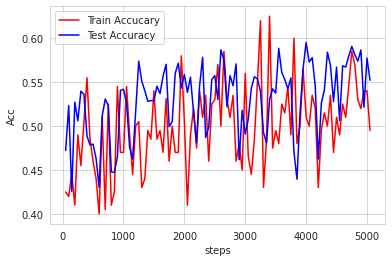

In [ ]:
plt.figure()
plt.plot(range(50,5051, 50), train_accuracies, 'r', range(50,5051, 50), valid_accuracies, 'b')
plt.legend(['Train Accucary','Test Accuracy'])
plt.xlabel('steps'), plt.ylabel('Acc')